In [1]:
library(tidyverse)
library(ggpubr)
library(treemapify)
library(vegan)
library(umap)
library(ggrepel)
library(rnaturalearth)
library(rnaturalearthdata)
library(sf)
library(ggpmisc)
library(mgcv)

source("../src/dd_functions.r")
source("../src/spreads.r")

options(jupyter.plot_scale=1)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘rnaturalearthdata’


The following object is masked from ‘package:rnaturalearth’:

    countries110


Linking to GEO

This notebook contains the code for running the analyses, creating tables and figures for the following sections:
* Figure 2
* Figure 3
* Figure S8
* Figure S9
* Table S2
* Table S3

In here, we are only using R code.

In [2]:
# Set the directory of where dataframes are saved
data.dir = '../data'

# Set the directory of where figures are saved to
fig.dir = '../fig'

In [3]:
# Load in metadata for samples and ARGs
metadata <- read_csv(
    file.path(data.dir, 'csv_files', 'metadata_fixed.csv'), 
    show_col_types=F
) %>%
    mutate(city = case_when(
            city == 'Santiago' & country == 'Spain' ~ 'Santiago_ESP',
            TRUE ~ city
        )
    )
panres.meta <- read_csv(
    file.path(data.dir, 'csv_files', 'panres_metadata_fixed.csv'), 
    show_col_types=F
)

New names:
• `` -> `...1`


In [4]:
# Load in and format the data output of flankophile
flankophile.dat <- read_delim(
    file = file.path(data.dir, 'data', 'flankophile_output', 'initial_run', '1_hits_all.tsv'), 
    show_col_types= F
) 

flankophile.dat1 <- flankophile.dat %>%
    mutate(
        tool = case_when(
            str_detect(pattern='spades', string = METADATA) ~ 'spades',
            TRUE ~ 'seed_extender'
        ),
        sampleName = basename(`#FILE`) %>% 
            str_replace_all(
                c(
                    ".scaf.min1000.fa" = "",
                    ".scaffolds.min1000.fasta" = "",
                    "_L\\d{3}$" =  "",
                    "P1$" = "",
                    "'_S\\d{3}$" = ""
                )
            )
        #.str.replace(r'_S\d+$', '', regex=True).str.replace(r'P1$', '', regex=True)
    ) %>% 
    filter(
        tool == 'spades'
    )

flankophile.dat2 <- flankophile.dat1 %>%
    mutate(
        genepid = as.double(str_extract(sampleName, "\\d{7}")),
        gene = str_extract(GENE, 'pan_\\d+')
    ) %>%
    left_join(
        metadata %>% distinct(genepid, city, country, Region,country_alpha3, year),
        by=c("genepid"),
        na_matches = "never"
    ) %>% 
     left_join(
        metadata %>% distinct(alternative_name, city, country, Region, country_alpha3, year), 
        by=c("sampleName" = "alternative_name"),
        na_matches = "never",
        relationship="many-to-many"
    ) %>%
    mutate(
        city = case_when(
            !is.na(city.x) ~ city.x,
            TRUE ~ city.y
            ),
        country = case_when(
            !is.na(country.x) ~ country.x,
            TRUE ~ country.y
        ),
        Region = case_when(
            !is.na(Region.x) ~ Region.x,
            TRUE ~ Region.y
        ),
        country_alpha3 = case_when(
            !is.na(country_alpha3.x) ~ country_alpha3.x,
            TRUE ~ country_alpha3.y
        ),
        year = case_when(
            !is.na(year.x) ~ year.x,
            TRUE ~ year.y
        )
    ) %>%
    select(-c(city.x, city.y, country.x, country.y, Region.x, Region.y, country_alpha3.x, country_alpha3.y, year.x, year.y)) %>%
    left_join(
        panres.meta %>% distinct(gene, group, class),
        by="gene",
        na_matches = "never"
    )%>%
    filter(!is.na(group)) %>%
    unique %>%
    mutate(
        class2 = str_split(str_replace_all(class, c("'" = "", "\\[" = "", "\\]" = "", " "="")), ","),
        variant = str_c(gene, VARIANT, sep = '_'),
        city = case_when(
            city == 'Santiago' & country == 'Spain' ~ 'Santiago_ESP',
            TRUE ~ city
        )
    )

flankophile.dat3 <- flankophile.dat2 %>% unnest_longer(class2)
resClasses <- sort(unique(flankophile.dat3$class2))


In [5]:
# Coloring palettes
dbpalette <- c("Acquired" = "#FC766AFF", "FG" = "#5B84B1FF")

region_palette = list(
    'East Asia & Pacific' = '#FEFF32',
    'Europe & Central Asia' = '#4BAD49',
    'Latin America & Caribbean' = '#A75529',
    'Middle East & North Africa' = '#974EA2',
    'North America' = '#FF8000',
    'South Asia' = '#3A7EB5',
    'Sub-Saharan Africa' = '#E4191C'
)

scale_palette = list(
    "Within Country" = "#F8766D", 
    "Within Region" = "#00BFC4", 
    "Between Regions" = "#C77CFF"
)


# Spread of alleles and variants

In [6]:
flankophile.dat2 %>%
    summarise(
        n_gene = n_distinct(gene),
        n_contigs = n_distinct(SEQUENCE),
        n_variants = n_distinct(variant)
    )

n_gene,n_contigs,n_variants
<int>,<int>,<int>
1633,83869,27217


In [7]:
flankophile.dat2 %>%
    group_by(group) %>%
    summarise(
        n_gene = n_distinct(gene),
        n_contigs = n_distinct(SEQUENCE),
        n_variants = n_distinct(variant),
        n_assembly = n_distinct(ASSEMBLY_NAME)
    )

group,n_gene,n_contigs,n_variants,n_assembly
<chr>,<int>,<int>,<int>,<int>
Functional,1181,56091,21119,1425
ResFinder,452,28482,6098,1426


In [8]:
flankophile.dat2 %>%
    group_by(group, gene) %>%
    summarise(n_variants = n_distinct(variant)) %>%
    group_by(group) %>%
    summarise(
        median_variants = median(n_variants),
        min_variants = min(n_variants),
        max_variants = max(n_variants)
        )

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.


group,median_variants,min_variants,max_variants
<chr>,<dbl>,<int>,<int>
Functional,4,1,325
ResFinder,3,1,269


In [10]:
flankophile.dat2 %>%
    group_by(group, variant) %>%
    summarise(
        n_contigs = n_distinct(SEQUENCE),
    ) %>%
    filter(n_contigs > 1) %>%
    group_by(group) %>%
    summarise(
        not_singleton = n_distinct(variant)
    )

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.


group,not_singleton
<chr>,<int>
Functional,3283
ResFinder,1060


In [11]:
spreadData <- generate_spread(
    dat1 = flankophile.dat2,
    dat2 = flankophile.dat3 %>% select(-class) %>% rename(class = class2),
    geo_levels=c("Region", "country", "city"),
    resClasses = resClasses
) %>% mutate(group=case_when(group == 'ResFinder' ~ "Acquired", T ~ "FG"))


[1] "ResFinder gene Region"


Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(geo_level)

  # Now:
  data %>% select(all_of(geo_level))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(arg_level)

  # Now:
  data %>% select(all_of(arg_level))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


[1] "ResFinder gene country"
[1] "ResFinder gene city"
[1] "ResFinder variant Region"
[1] "ResFinder variant country"
[1] "ResFinder variant city"
[1] "Functional gene Region"
[1] "Functional gene country"
[1] "Functional gene city"
[1] "Functional variant Region"
[1] "Functional variant country"
[1] "Functional variant city"


### Figure S8

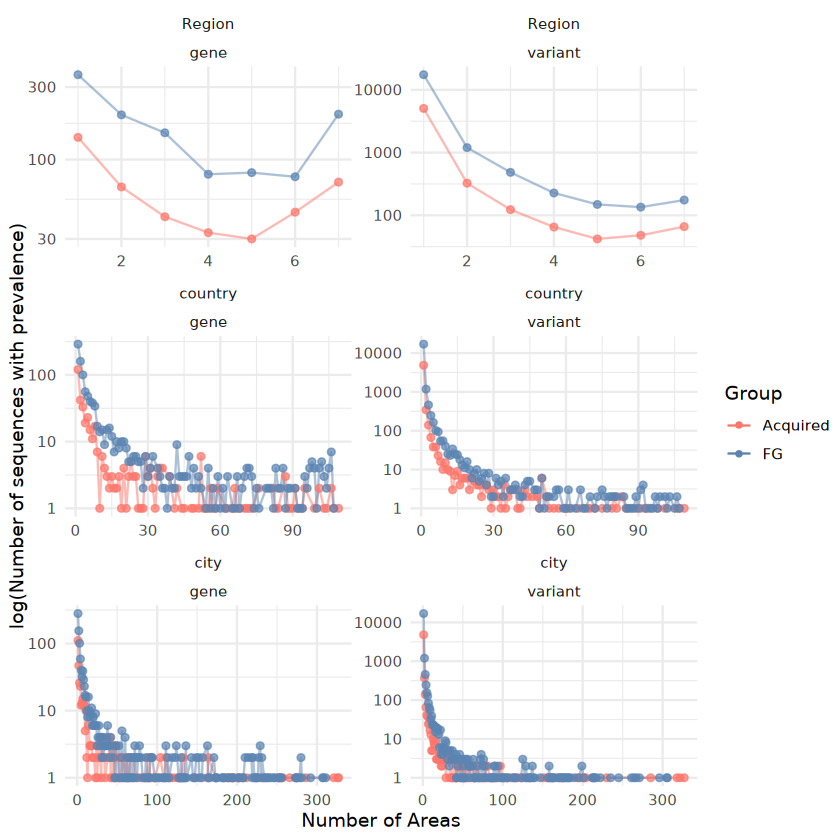

In [12]:
spreadData %>% filter(res_class == 'All') %>%
    ggplot(aes(x=numberAreas, y = n, color=factor(group, levels=c('Acquired', 'FG')))) +
    geom_line(alpha = .5) +
    geom_point(alpha = .7) + 
    facet_wrap(geo_level ~ arg_level, scales='free', ncol = 2) +
    scale_y_log10() +
    scale_color_manual(values = dbpalette) +
    theme_minimal() +
        labs(
            y="log(Number of sequences with prevalence)",
             x = "Number of Areas"
        ) +
    guides(
        col = guide_legend(title='Group', override.aes = list(shape=16, alpha=1, lw=0))
    )

ggsave(
    filename=file.path(fig.dir, "all_spreads_areas_log10.png"),
    height=11.7, width=8.3
)
ggsave(
    filename=file.path(fig.dir, "all_spreads_areas_log10.pdf"),
    height=11.7, width=8.3
)

# Distance-Decays

## Distance-Decay of Quantified Resistomes (Abundances)

In [13]:
resfinder_clr <- read_csv(file.path(data.dir, 'csv_files', 'clr_city_resfinder.csv'), show_col_types = F)
functional_clr <- read_csv(file.path(data.dir, 'csv_files', 'clr_city_functional.csv'), show_col_types = F)
genera_clr <- read_csv(file.path(data.dir, 'csv_files', 'clr_city_genera.csv'), show_col_types = F)

In [14]:
# Distances between cities
city_dists <- create_physical_dd(metadata, geoCol='city')

# Resistome CLR similarities with Euclidean distances
resfinder_clr_dists <- make_clr_similarity(resfinder_clr, id_col='city', method='euclidean')
functional_clr_dists <- make_clr_similarity(functional_clr, id_col='city', method='euclidean')
genera_clr_dists <- make_clr_similarity(genera_clr, id_col='city', method='euclidean')

abn.dists.regions <- city_dists %>%
    left_join(resfinder_clr_dists, by=c("area1" = "city", "area2" = "city_2")) %>%
    left_join(functional_clr_dists, by=c("area1" = "city", "area2" = "city_2"), suffix=c(".rf", ".func")) %>%
    left_join(genera_clr_dists, by=c("area1" = "city", "area2" = "city_2")) %>%
    mutate(
        across(starts_with("sim."), ~ 1 - .x, .names = "dis{.col}")
    ) %>%
    left_join(
        metadata %>% distinct(city, country, Region), by=c("area1" = "city")
    )%>%
    left_join(
        metadata %>% distinct(city, country, Region), by=c("area2" = "city"), suffix=c(".1", ".2")
    ) %>%
    filter(across(everything(), ~!is.na(.) & !is.nan(.))) %>% 
    mutate(
        dist_km = as.numeric(value) / 1000,
        log_distance = log(dist_km),
        log_rf_similarity = log(sim.euclidean.rf),
        log_fg_similarity = log(sim.euclidean.func),
        log_bac_similarity = log(sim.euclidean),
        log_rf_dissimilarity = log(1-sim.euclidean.rf),
        log_fg_dissimilarity = log(1-sim.euclidean.func),
        log_bac_dissimilarity = log(1-sim.euclidean),
        spatial_scale = factor(
                    case_when(
                    country.1 == country.2 ~ 'Within Country',
                    country.1 != country.2 & Region.1 == Region.2 ~ 'Within Region',
                    TRUE ~ 'Between Regions'
                ),
                levels=c('Within Country', 'Within Region', 'Between Regions')
            )
    )

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(drop_columns)

  # Now:
  data %>% select(all_of(drop_columns))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `

In [15]:
min(abn.dists.regions%>% filter(dist_km > 0) %>% pull(dist_km))

[1] 0.07885298

In [435]:
run_mantel(
    data = abn.dists.regions,
    x = 'log_bac_dissimilarity',
    y = 'log_rf_dissimilarity'
    
)$table

r,p.value,signif
<dbl>,<dbl>,<chr>
0.7,0.001,**


In [436]:
run_mantel(
    data = abn.dists.regions,
    x = 'log_bac_dissimilarity',
    y = 'log_fg_dissimilarity'
    
)$table

r,p.value,signif
<dbl>,<dbl>,<chr>
0.76,0.001,**


In [437]:
run_mantel(
    data = abn.dists.regions,
    x = 'log_rf_dissimilarity',
    y = 'log_fg_dissimilarity'
    
)$table

r,p.value,signif
<dbl>,<dbl>,<chr>
0.78,0.001,**


### Figure 2

In [21]:
min_maxs <- abn.dists.regions %>% summarise(across(where(is.numeric), list(min=min, max=max), na.rm=T))

ymin <- min(min_maxs %>% select(log_rf_similarity_min, log_fg_similarity_min, log_bac_similarity_min))
ymax <- max(min_maxs %>% select(log_rf_similarity_max, log_fg_similarity_max, log_bac_similarity_max))


In [22]:
abn.dists.rf.lms <- build_lms(
    abn.dists.regions, 
    x = 'log_distance', 
    y = 'log_rf_similarity', 
    z='spatial_scale',
    palette = scale_palette,
    calc_mantel = T,
    xlabel = 'Ln(Geodesic distance) (km)',
    ylabel = 'Ln(Resistome Similarity) (Euclidean)',
    title='Distance-Decay of abundance of acquired genes',
    ymin = ymin, 
    ymax = ymax
)

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- da

In [23]:
abn.dists.fg.lms <- build_lms(
    abn.dists.regions, 
    x = 'log_distance', 
    y = 'log_fg_similarity', 
    z='spatial_scale',
    palette = scale_palette,
    calc_mantel = T,
    xlabel = 'Ln(Geodesic distance) (km)',
    ylabel = 'Ln(Resistome Similarity) (Euclidean)',
    title='Distance-Decay of abundance of FG genes',
    ymin = ymin, 
    ymax = ymax
)

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1)

In [24]:
abn.dists.bac.lms <- build_lms(
    abn.dists.regions, 
    x = 'log_distance', 
    y = 'log_bac_similarity', 
    z='spatial_scale',
    palette = scale_palette,
    calc_mantel = T,
    xlabel = 'Ln(Geodesic distance) (km)',
    ylabel = 'Ln(Bacteriome Similarity) (Euclidean)',
    title='Distance-Decay of abundance of bacterial genera',
    ymin = ymin, 
    ymax = ymax
)

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1)

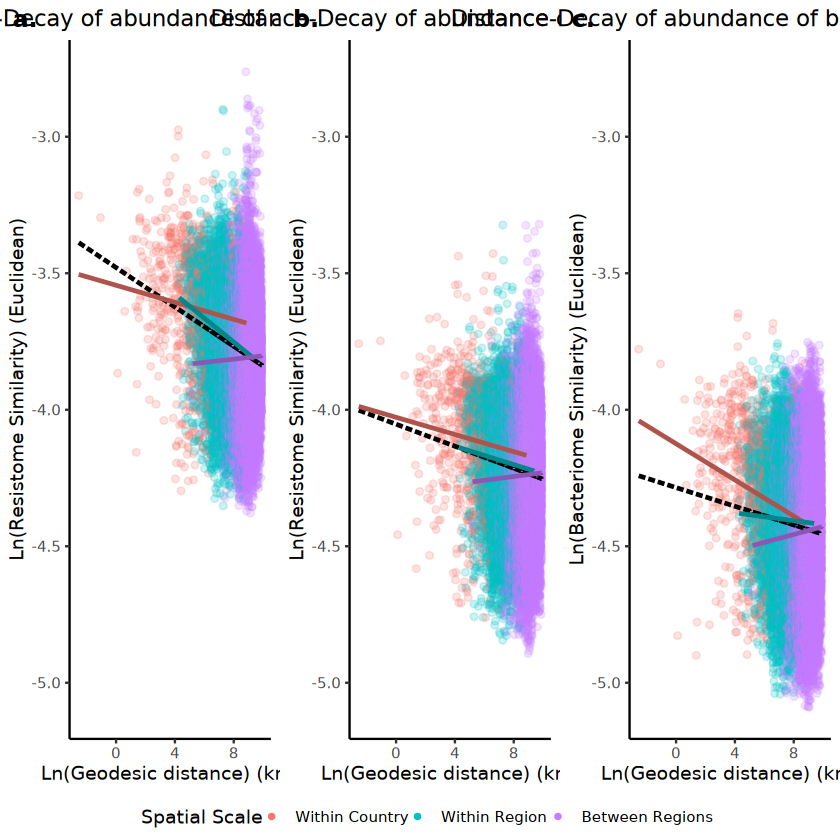

In [25]:
ggarrange(
    abn.dists.rf.lms$p, abn.dists.fg.lms$p, abn.dists.bac.lms$p,
    nrow=1,ncol=3,
    common.legend = T,
    legend = "bottom",
    labels = c("a.", "b.", "c.")
)

ggsave(file.path(fig.dir, "dd_plots_abundances_euclidean_sim.png"), height = 6, width = 15)

Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_lines, x$x, x$y, ind

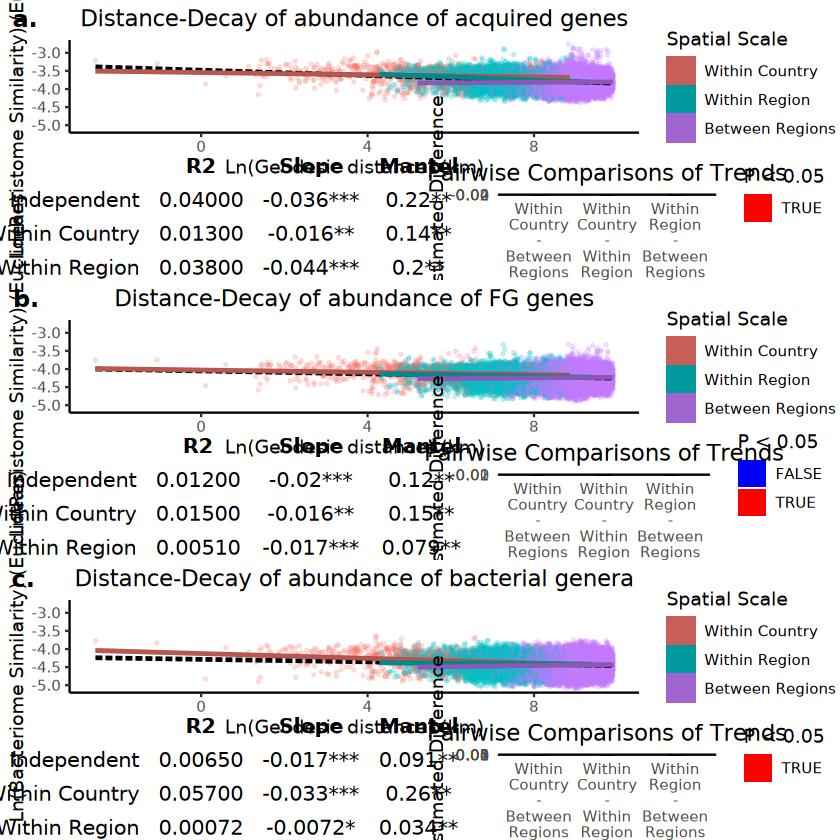

In [26]:
ggarrange(
    abn.dists.rf.lms$p2, abn.dists.fg.lms$p2, abn.dists.bac.lms$p2,
    nrow=3,ncol=1,
    labels = c("a.", "b.", "c.")
)

ggsave(file.path(fig.dir, "dd_plots_abundances_euclidean_sim_extended.png"), height = 25, width = 10, bg="white")

### Slopes

In [27]:
abn.lm.summaries <- rbind(
    abn.dists.rf.lms$fit.summaries %>% left_join(abn.dists.rf.lms$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'Acquired'),
    abn.dists.fg.lms$fit.summaries %>% left_join(abn.dists.fg.lms$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'FG'),
    abn.dists.bac.lms$fit.summaries%>% left_join(abn.dists.bac.lms$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'Genera')
)

In [428]:
rbind(
    abn.dists.rf.lms$pairs %>% mutate(group = 'RF'),
    abn.dists.fg.lms$pairs %>% mutate(group = 'FG'),
    abn.dists.bac.lms$pairs %>% mutate(group = 'Bac')
) %>% mutate(
    star = case_when(
                    `p.value` <= 0.0001 ~ '***',
                    `p.value` <= 0.001 ~ '**',
                    `p.value` <= 0.01 ~ '*',
                    `p.value` <= 0.05 ~ '.',
                    TRUE ~ ' '
                )
    )

contrast,estimate,SE,df,t.ratio,p.value,group,star
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Within Country - Within Region,0.028158280,0.003772373,60024,7.4643412,2.711165e-13,RF,***
Within Country - Between Regions,-0.021555511,0.003566938,60024,-6.0431412,4.532657e-09,RF,***
Within Region - Between Regions,-0.049713791,0.002434640,60024,-20.4193575,0.000000e+00,RF,***
Within Country - Within Region,0.001002795,0.003978016,60024,0.2520842,9.655762e-01,FG,
Within Country - Between Regions,-0.022676931,0.003761383,60024,-6.0288818,4.951124e-09,FG,***
Within Region - Between Regions,-0.023679726,0.002567360,60024,-9.2233765,3.341771e-14,FG,***
Within Country - Within Region,-0.025918230,0.004511503,60024,-5.7449221,2.757039e-08,Bac,***
Within Country - Between Regions,-0.047640748,0.004265816,60024,-11.1680260,8.659740e-15,Bac,***
Within Region - Between Regions,-0.021722517,0.002911665,60024,-7.4605144,2.781109e-13,Bac,***


## Distance-Decay of Assembled Resistomes

In [29]:
resClassObjs <- c()

resClassObjs$all <- c()
resClassObjs$all$variant <-  run_all(flankophile.dat2, metadata, geneCol='variant',title=paste('Entire resistome', '-', 'exact variant'))
 resClassObjs$all$gene <-  run_all(flankophile.dat2, metadata, geneCol='gene',title=paste('Entire resistome', '-', 'closest reference'))

for(resClass in resClasses){
    sel.dat <- flankophile.dat3 %>% filter(class2 == resClass)
    print(paste(resClass))
    resClassObjs[[resClass]]$gene <- run_all(sel.dat, metadata, verbose=T, title=paste(str_to_title(resClass), '-', 'closest reference'))
    resClassObjs[[resClass]]$variant <- run_all(sel.dat, metadata, verbose=T, geneCol='variant', title=paste(str_to_title(resClass), '-', 'exact variant'))
}

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "aminoglycoside"
[1] "ResFinder data input: 6610 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "Functional data input: 3456 29"
[1] "ResFinder distance matrix: 3 6"
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 6610 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "Functional data input: 3456 29"
[1] "ResFinder distance matrix: 3 6"
[1] "Functional distance matrix:  "
[1] "beta_lactam"
[1] "ResFinder data input: 4879 29"
[1] "Functional data input: 23128 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 2145 6"
[1] "ResFinder data input: 4879 29"
[1] "Functional data input: 23128 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 2145 6"
[1] "fluoroquinolone"
[1] "ResFinder data input: 5 29"
[1] "Functional data input: 17142 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 528 6"
[1] "ResFinder data input: 5 29"
[1] "Functional data input: 17142 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 528 6"
[1] "folate_pathway_antagonist"
[1] "ResFinder data input: 1916 29"
[1] "Functional data input: 5488 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 1 6"
[1] "ResFinder data input: 1916 29"
[1] "Functional data input: 5488 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 1 6"
[1] "fosfomycin"
[1] "ResFinder data input: 183 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 183 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "glycopeptide"
[1] "ResFinder data input: 36 29"
[1] "Functional data input: 7523 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 28 6"
[1] "ResFinder data input: 36 29"
[1] "Functional data input: 7523 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 28 6"
[1] "lincosamide"
[1] "ResFinder data input: 4169 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix: 0 6"
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 4169 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix: 0 6"
[1] "Functional distance matrix:  "
[1] "macrolide"
[1] "ResFinder data input: 9965 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix: 78 6"
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 9965 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix: 78 6"
[1] "Functional distance matrix:  "
[1] "nitroimidazole"
[1] "ResFinder data input: 118 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 118 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "other"
[1] "ResFinder data input: 4 29"
[1] "Functional data input: 18106 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 903 6"
[1] "ResFinder data input: 4 29"
[1] "Functional data input: 18106 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 903 6"
[1] "oxazolidinone"
[1] "ResFinder data input: 148 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 148 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "peptide"
[1] "ResFinder data input: 133 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 133 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "phenicol"
[1] "ResFinder data input: 740 29"
[1] "Functional data input: 1132 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 740 29"
[1] "Functional data input: 1132 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "pleuromutilin"
[1] "ResFi

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 10 6"
[1] "ResFinder data input: 92 29"
[1] "Functional data input: 6303 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 10 6"
[1] "quinolone"
[1] "ResFinder data input: 1547 29"
[1] "Functional data input: 326 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 1547 29"
[1] "Functional data input: 326 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "rifampicin"
[1] "ResFinder data input: 221 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 221 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "streptogramin_a"
[1] "ResFinder data input: 778 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "ResFinder data input: 778 29"
[1] "Functional data input: 0 29"
[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix:  "
[1] "streptogramin_b"
[1]

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 1081 6"
[1] "ResFinder data input: 2607 29"
[1] "Functional data input: 19733 29"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”


[1] "ResFinder distance matrix:  "
[1] "Functional distance matrix: 1081 6"


In [30]:
alldists <- resClassObjs$all$variant$dists%>%
        left_join(
            metadata %>% distinct(country, city) %>% rename(area1 = city), 
            by = "area1") %>%
        left_join(
            metadata %>% distinct(country, city) %>% rename(area2 = city), 
            by = "area2", suffix = c(".1", ".2")
        ) %>% mutate(
            dissimilarity = value.res,
            log_dissimilarity = log(value.res),
            similarity = 1-value.res,
            log_similarity = log(similarity),
            log_distance = log(dist_km),
            spatial_scale = factor(
                case_when(
                    country.1 == country.2 ~ 'Within Country',
                    country.1 != country.2 & Region.1 == Region.2 ~ 'Within Region',
                    TRUE ~ 'Between Regions'
                ),
                levels=c('Within Country', 'Within Region', 'Between Regions')
            )
        )

### DD plots

In [31]:
ymin = log(min(alldists$similarity))
ymax = log(max(alldists$similarity))
           
variants.dists.rf.lms <- build_lms(
    alldists %>% filter(group == 'ResFinder'), 
    x = 'log_distance', 
    y = 'log_similarity', 
    z='spatial_scale',
    palette = scale_palette,
    calc_mantel = T,
    xlabel = 'Ln(Geodesic distance) (km)',
    ylabel = 'Ln(Resistome Similarity) (Bray-Curtis)',
    title='Distance-Decay of assembled acquired variants',
    ymin = ymin, 
    ymax = ymax
)
           
variants.dists.fg.lms <- build_lms(
    alldists %>% filter(group != 'ResFinder'), 
    x = 'log_distance', 
    y = 'log_similarity', 
    z='spatial_scale',
    palette = scale_palette,
    calc_mantel = T,
    xlabel = 'Ln(Geodesic distance) (km)',
    ylabel = 'Ln(Resistome Similarity) (Bray-Curtis)',
    title='Distance-Decay of assembled FG variants',
    ymin = ymin, 
    ymax = ymax
)

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”


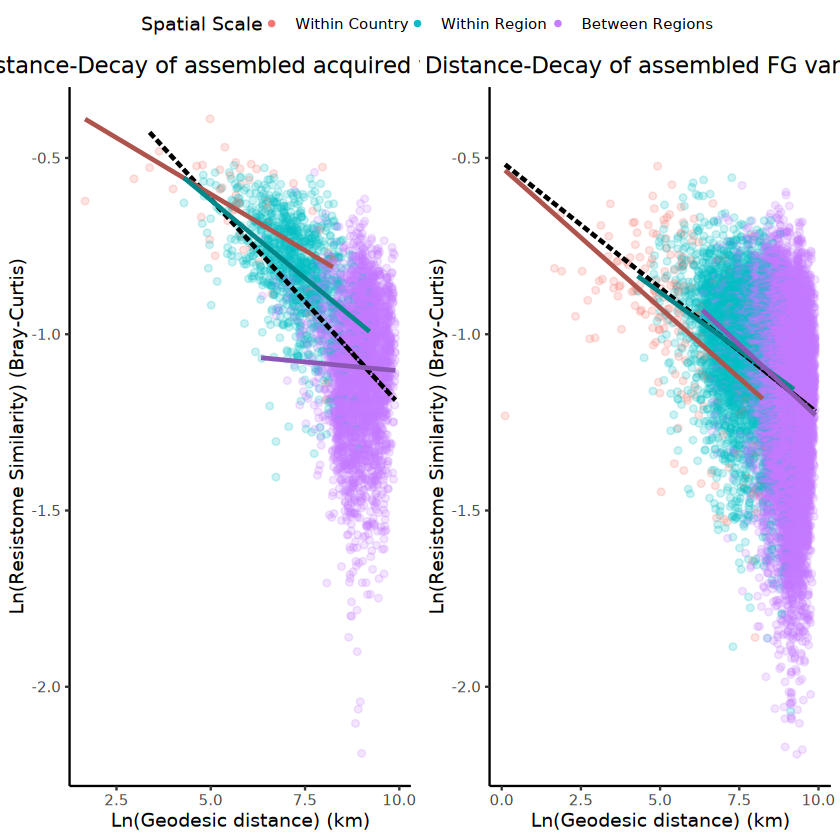

In [32]:
ggarrange(variants.dists.rf.lms$p, variants.dists.fg.lms$p, ncol = 2,nrow=1, common.legend=T)

Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
“supplied color is neither numeric nor character”
Warning message in grid.Call.graphics(C_lines, x$x, x$y, ind

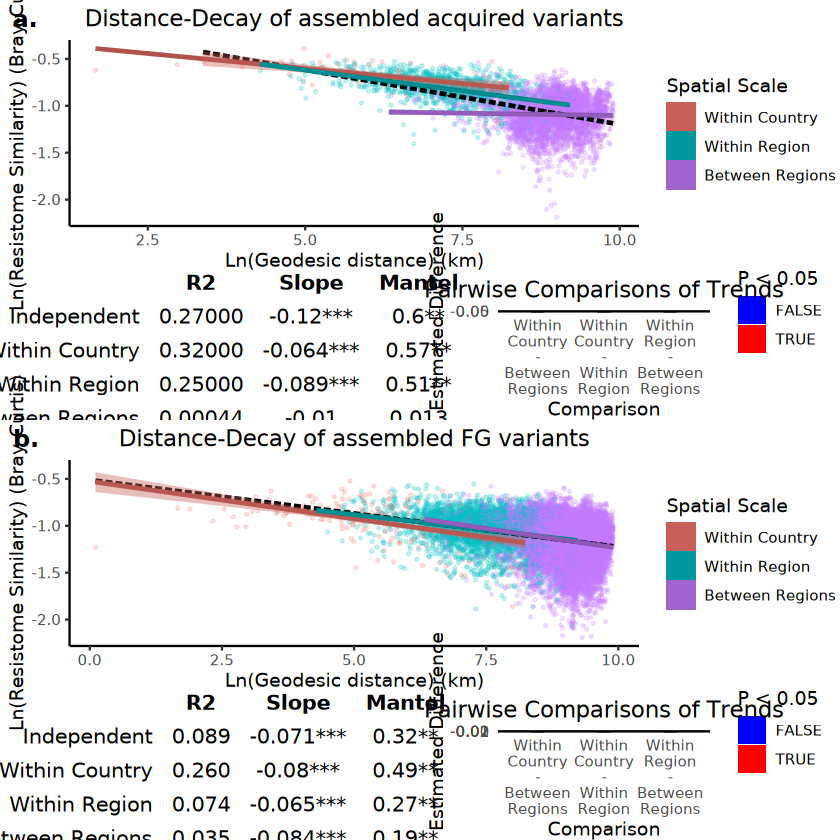

In [418]:
ggarrange(
    variants.dists.rf.lms$p2, 
    variants.dists.fg.lms$p2, 
    ncol = 1,nrow=2,
    labels = c("a.", "b.")
)

ggsave(file.path(fig.dir, "dd_plots_assembled_variants_extended.png"), height = 18, width = 10, bg="white")
ggsave(file.path(fig.dir, "dd_plots_assembled_variants_extended.tiff"), height = 18, width = 10, bg="white")
ggsave(file.path(fig.dir, "dd_plots_assembled_variants_extended.pdf"), height = 18, width = 10, bg="white")

In [427]:
rbind(
    variants.dists.rf.lms$pairs %>% mutate(group = 'RF'),
    variants.dists.fg.lms$pairs %>% mutate(group = 'FG')
) %>% mutate(
    star = case_when(
                    `p.value` <= 0.0001 ~ '***',
                    `p.value` <= 0.001 ~ '**',
                    `p.value` <= 0.01 ~ '*',
                    `p.value` <= 0.05 ~ '.',
                    TRUE ~ ' '
                )
    )

contrast,estimate,SE,df,t.ratio,p.value,group,star
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Within Country - Within Region,0.024730711,0.017783945,4650,1.3906201,3.458744e-01,RF,
Within Country - Between Regions,-0.053753461,0.017503119,4650,-3.0710790,6.076167e-03,RF,*
Within Region - Between Regions,-0.078484173,0.008916512,4650,-8.8021161,3.897619e-08,RF,***
Within Country - Within Region,-0.014592215,0.010704821,16465,-1.3631443,3.604269e-01,FG,
Within Country - Between Regions,0.003904697,0.010337035,16465,0.3777386,9.243698e-01,FG,
Within Region - Between Regions,0.018496912,0.005973489,16465,3.0965006,5.567220e-03,FG,*


### UMAP

In [274]:
n.variants.city <- rbind(
    as.data.frame(list("n_variants" = colSums(resClassObjs$all$variant$rf.res$mat), group = "Acquired")) %>% rownames_to_column('city'),
    as.data.frame(list("n_variants" = colSums(resClassObjs$all$variant$func.res$mat), group = "FG")) %>% rownames_to_column('city')
)

umap.dfs <- rbind(
    create_umap(resClassObjs$all$variant$rf.res$filtered) %>% mutate(group = 'Acquired'),
    create_umap(resClassObjs$all$variant$func.res$filtered) %>% mutate(group = 'FG')
) %>%
    left_join(n.variants.city, by=c("city", "group")) %>%
    left_join(metadata %>% distinct(city, Region), by="city")

### Figure 3

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“ggrepel: 96 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 178 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 80 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 149 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 78 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 142 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


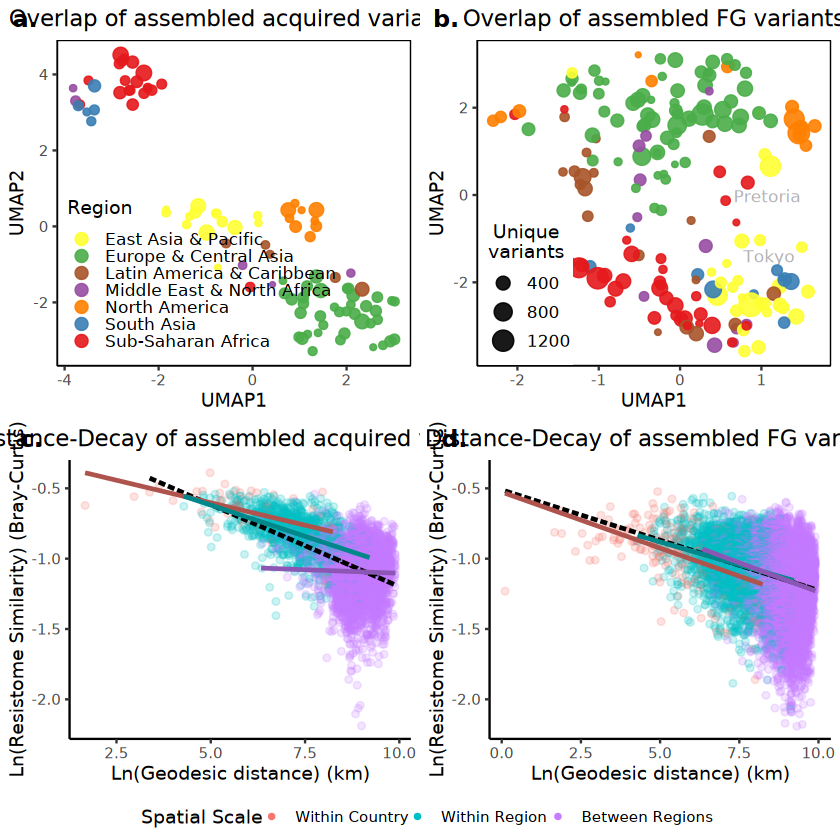

In [417]:
max.overlaps.rf = 8
max.overlaps.fg = 6
lw = .3
fontsize = 3.5
fontopacity = .3

p.umap.variant.rf <- umap.dfs %>%
    filter(group == 'Acquired') %>%
    ggplot(aes(X1, X2)) +
    geom_text_repel(aes(label=city), alpha = fontopacity, max.overlaps = max.overlaps.rf, size = fontsize) +
    geom_point(aes(size=n_variants, color=Region), alpha = .9) + 
    scale_color_manual(values=region_palette) +
    scale_size(limits = c(min(umap.dfs$n_variants), max(umap.dfs$n_variants))) + 
    labs(x='UMAP1', y='UMAP2', title = 'Overlap of assembled acquired variants') + 
    theme(
            legend.text=element_text(size=10),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_rect(color="black", fill = NA, linewidth = lw),
            panel.background = element_blank(),
            axis.line = element_line(colour = "black", linewidth = lw),
            #axis.ticks = element_blank(),
            #axis.text = element_blank(),
            plot.title = element_text(hjust = 0.5),
            legend.position = c("bottom", "left"),
            legend.justification = c(0.01, 0.01),
            legend.key.spacing.y = unit(-0.25, "cm"),
            legend.background = element_rect(color = NA, fill = NA)
        ) +
    guides(
        size = "none", #guide_legend(title="Region", title.position="top", title.hjust = 0.5),
        color = guide_legend(title="Region", byrow=T, override.aes = aes(size=3))
    )

p.umap.variant.fg <- umap.dfs %>%
    filter(group != 'Acquired') %>%
    ggplot(aes(X1, X2)) +
    geom_text_repel(aes(label=city), alpha = fontopacity, max.overlaps = max.overlaps.fg, size = fontsize) +
    geom_point(aes(size=n_variants, color=Region), alpha = .9) + 
    scale_color_manual(values=region_palette) +
    scale_size(limits = c(min(umap.dfs$n_variants), max(umap.dfs$n_variants))) + 
    labs(x='UMAP1', y='UMAP2', title = 'Overlap of assembled FG variants') + 
    theme(
            legend.text=element_text(size=10),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_rect(color="black", fill = NA, linewidth = lw),
            panel.background = element_blank(),
            axis.line = element_line(colour = "black", linewidth = lw),
            #axis.ticks = element_blank(),
            #axis.text = element_blank(),
            plot.title = element_text(hjust = 0.5),
            legend.position = c("bottom", "left"),
            legend.justification = c(0.01, 0.01)
        ) +
    guides(
        color = "none", #guide_legend(title="Region", title.position="top", title.hjust = 0.5, byrow=T, override.aes = aes(size=2)),
        size = guide_legend(title="Unique\nvariants", title.position="top", title.hjust = 0.5)
    )

p.umap.variant.all <- ggarrange(p.umap.variant.rf, p.umap.variant.fg, ncol=2,nrow=1, labels=c("a.", "b."))

ggarrange(
    #ggarrange(p.umap.variant.resfinder, p.umap.variant.functional, ncol=2, nrow=1, common.legend =T, labels=c("a.  ", "b.  "), legend="bottom"),
    p.umap.variant.all,
    ggarrange(variants.dists.rf.lms$p, variants.dists.fg.lms$p, ncol=2, nrow=1, common.legend = T, labels=c("c.  ", "d.  "), legend="bottom"),
    ncol = 1, nrow = 2
)

ggsave(
    file.path(fig.dir, "umap_dd_plots_variant_similarity_v2.png"), 
    width = 11, height = 10
)

ggsave(
    file.path(fig.dir, "umap_dd_plots_variant_similarity_v2.pdf"), 
    width = 11, height = 10
)

### Slopes


In [36]:
var.lm.summaries <- rbind(
    variants.dists.rf.lms$fit.summaries %>% left_join(variants.dists.rf.lms$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'Acquired'),
    variants.dists.fg.lms$fit.summaries %>% left_join(variants.dists.fg.lms$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'FG')
)

### DDs within each region

In [37]:
resRegionClassObjs <- c()

metadata.2 <- metadata %>%
    mutate(
        city = case_when(
            city == 'Santiago' & country == 'Spain' ~ 'Santiago_ESP',
            TRUE ~ city
        )
    )

for(region in names(region_palette)){
    resClassObjs <- c()
    
    resClassObjs$all$variant <-  run_all(flankophile.dat2[which(flankophile.dat2$Region == region),], metadata.2, geneCol='variant',title=paste('Entire resistome', '-', 'exact variant'))
     resClassObjs$all$gene <-  run_all(flankophile.dat2[which(flankophile.dat2$Region == region),], metadata.2, geneCol='gene',title=paste('Entire resistome', '-', 'closest reference'))
    
    resRegionClassObjs[[region]] <- resClassObjs
    print(region)
}
    

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "East Asia & Pacific"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "Europe & Central Asia"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "Latin America & Caribbean"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "Middle East & North Africa"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "North America"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "South Asia"


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
Warning message in st_is_longlat(x):
“bounding box has potentially

[1] "Sub-Saharan Africa"


In [38]:
plotlist.dd.regions = list()
plotlist.dd.regions.extended = list()
summaries.dd.regions = list()

model_fits <- list()
for(region in names(region_palette)){
    print(region)
    alldists.region <- resRegionClassObjs[[region]]$all$variant$dists %>%
        left_join(metadata.2 %>% distinct(country, city) %>% rename(area1 = city), by = "area1") %>%
        left_join(metadata.2 %>% distinct(country, city) %>% rename(area2 = city), by = "area2", suffix = c(".1", ".2")) %>% mutate(
            dissimilarity = value.res,
            log_dissimilarity = log(value.res),
            similarity = 1-value.res,
            log_similarity = log(similarity),
            log_distance = log(dist_km),
            spatial_scale = factor(
                case_when(
                    country.1 == country.2 ~ 'Within Country',
                    country.1 != country.2 & Region.1 == Region.2 ~ 'Within Region',
                    TRUE ~ NA
                ),
                levels=c('Within Country', 'Within Region')
            )
        )

    ymin <- log(min(1-alldists.region$value.res))
    ymax <- log(max(1-alldists.region$value.res))

    p.dd.resfinder.gene.similarity <- build_lms(
        alldists.region %>% filter(group == 'ResFinder'), 
        x = 'log_distance', 
        y = 'log_similarity', 
        z='spatial_scale',
        palette = scale_palette,
        calc_mantel = T,
        xlabel = 'Ln(Geodesic distance) (km)',
        ylabel = 'Ln(Resistome Similarity) (Bray-Curtis)',
        title=paste(region, "\n", 'assembled acquired variants'),
        ymin = ymin, 
        ymax = ymax
    )

    p.dd.functional.gene.similarity <- build_lms(
        alldists.region %>% filter(group != 'ResFinder'), 
        x = 'log_distance', 
        y = 'log_similarity', 
        z='spatial_scale',
        palette = scale_palette,
        calc_mantel = T,
        xlabel = 'Ln(Geodesic distance) (km)',
        ylabel = 'Ln(Resistome Similarity) (Bray-Curtis)',
        title='assembled FG variants',
        ymin = ymin, 
        ymax = ymax
    )


    p.dd.both <- ggarrange(p.dd.resfinder.gene.similarity$p, p.dd.functional.gene.similarity$p, ncol = 1,nrow=2, common.legend=T, legend = "bottom")
    plotlist.dd.regions[[region]] <- p.dd.both


    p.dd.both.ext <- ggarrange(p.dd.resfinder.gene.similarity$p2, p.dd.functional.gene.similarity$p2, ncol = 1,nrow=2)
    plotlist.dd.regions.extended[[region]] <- p.dd.both

    region.var.lm.summaries <- rbind(
        p.dd.resfinder.gene.similarity$fit.summaries %>% left_join(p.dd.resfinder.gene.similarity$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'Acquired'),
        p.dd.functional.gene.similarity$fit.summaries %>% left_join(p.dd.functional.gene.similarity$mantel.results, by = ("model"), suffix = c(".fit", ".mantel")) %>% mutate(Collection = 'FG')
    ) %>% mutate(region = region)

    summaries.dd.regions <- rbind(summaries.dd.regions, region.var.lm.summaries)

}

[1] "East Asia & Pacific"


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.

Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_line()`).”
Warnin

[1] "Europe & Central Asia"


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` inst

[1] "Latin America & Caribbean"


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.

Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of 

[1] "Middle East & North Africa"


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.

'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.

Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!

[1] "North America"


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of it

[1] "South Asia"


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.

'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.t

[1] "Sub-Saharan Africa"


Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in y.mat[upper.tri(y.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of items to replace is not a multiple of replacement length”
Warning message in x.mat[upper.tri(x.mat)] <- data %>% arrange(!!sym(g1), !!sym(g2)) %>% :
“number of it

#### Figure S9

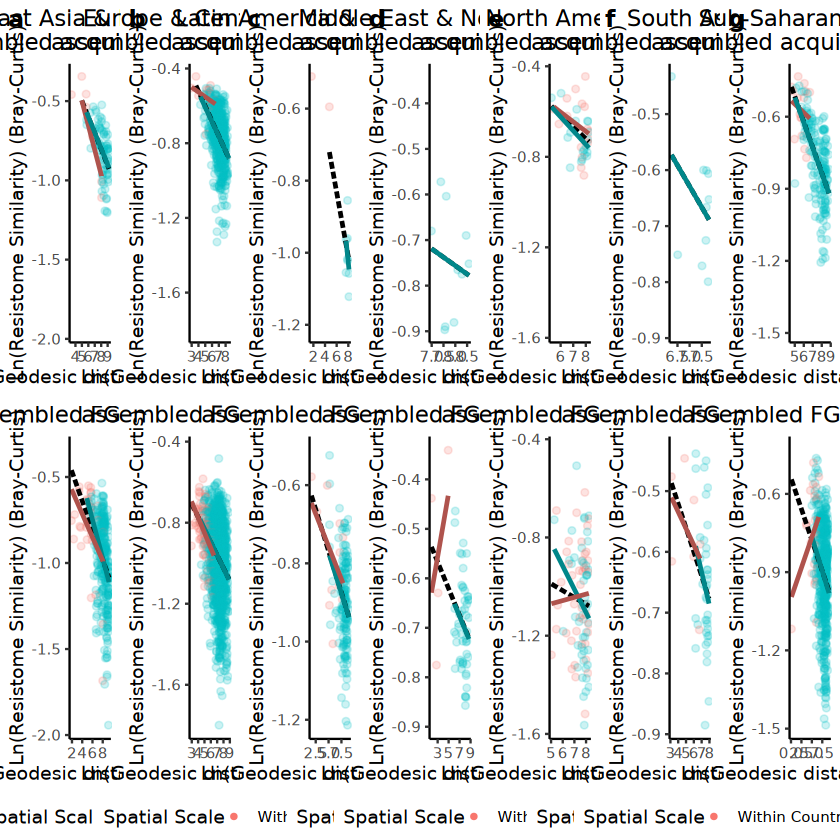

In [39]:
ggarrange(plotlist=plotlist.dd.regions, labels="auto", nrow=1)
ggsave(file.path(fig.dir, "dd_arg_variant_regions.png"), width = 20, height = 7)

## Fit Summaries and Mantel tests

In [40]:
gts <- function(gt_table){
   gt:::as.tags.gt_tbl(gt_table)
}

In [43]:
library(gt)

In [44]:
overall.lm.summaries.long <- rbind(
    abn.lm.summaries %>% mutate("Data.Type" = "Abundance"),
    var.lm.summaries %>% mutate("Data.Type" = "Assembly variants")
) %>%
    mutate(
        Slope = paste0(Slope, signif.fit, '<br>(P=', signif(P.value, 3), ')'),
        Mantel = paste0(r, signif.mantel, '\n(P=', signif(p.value, 3), ')'),
        R2 = paste0(R2)
    ) %>% 
    select(Data.Type, Collection, model, R2, Slope, Mantel) %>%
    pivot_longer(-c(`Data.Type`, `Collection`, `model`))

overall.lm.summaries.long %>%
    pivot_wider(
        names_from=c('Data.Type', 'Collection'),
        id_cols=c('model', 'name'),
        values_from='value'
    ) %>%
    gt() %>%
    tab_spanner_delim(delim='_', split = "first") %>%
    tab_style(
        style = cell_text(weight="bold"),
        locations = cells_column_spanners(spanners=c("spanner-Abundance_Acquired", "spanner-Assembly variants_Acquired"))
    ) %>%
    tab_style(
        style=cell_text(weight=600), locations = cells_column_labels()
    ) %>%
    fmt_markdown(columns = TRUE) %>%
    #cols_label(
    #    Data.Type = md("**Data Type**"),
    #    Collection = md("**Collection**")
    #  ) %>%
    #cols_align(
    #  align = "center",
    #  columns = everything()
    #) %>%
    #tab_info() %>%
    gts()

Warning message:
“Since gt v0.3.0, `columns = TRUE` has been deprecated.
• Please use `columns = everything()` instead.”


Shiny tags cannot be represented in plain text (need html)

In [45]:
summaries.dd.regions.long <- summaries.dd.regions %>%
    mutate(
        Slope = paste0(Slope, signif.fit, '<br>(P=', signif(P.value, 3), ')'),
        Mantel = paste0(r, signif.mantel, '<br>(P=', signif(p.value, 3), ')'),
        R2 = paste0(R2)
    ) %>%
    select(region, Collection, model, R2, Slope, Mantel) %>%
    pivot_longer(-c(`region`, `Collection`, `model`))

summaries.dd.regions.long %>%
    pivot_wider(
        id_cols=c('region', 'Collection'),
        names_from=c('model', 'name'),
        values_from='value'
    ) %>%
    gt() %>%
    tab_spanner_delim(delim='_', split = "first") %>%
    tab_style(
        style = cell_text(weight="bold"),
        locations = cells_column_spanners(spanners=c("spanner-Independent_R2", "spanner-Within Country_R2", "spanner-Within Region_R2"))
    ) %>%
    tab_style(
        style=cell_text(weight=600), locations = cells_column_labels()) %>%
    fmt_markdown(columns = TRUE) %>%
    cols_label(
        region = md("**Region**"),
        Collection = md("**Collection**")
      ) %>%
    cols_align(
      align = "center",
      columns = everything()
    ) %>%
    gts()

Warning message:
“Since gt v0.3.0, `columns = TRUE` has been deprecated.
• Please use `columns = everything()` instead.”


Shiny tags cannot be represented in plain text (need html)

### Comparison of trends

In [46]:
abn.dists.rf.lms$pairs$contrast

[1] "Within Country - Within Region"   "Within Country - Between Regions"
[3] "Within Region - Between Regions"

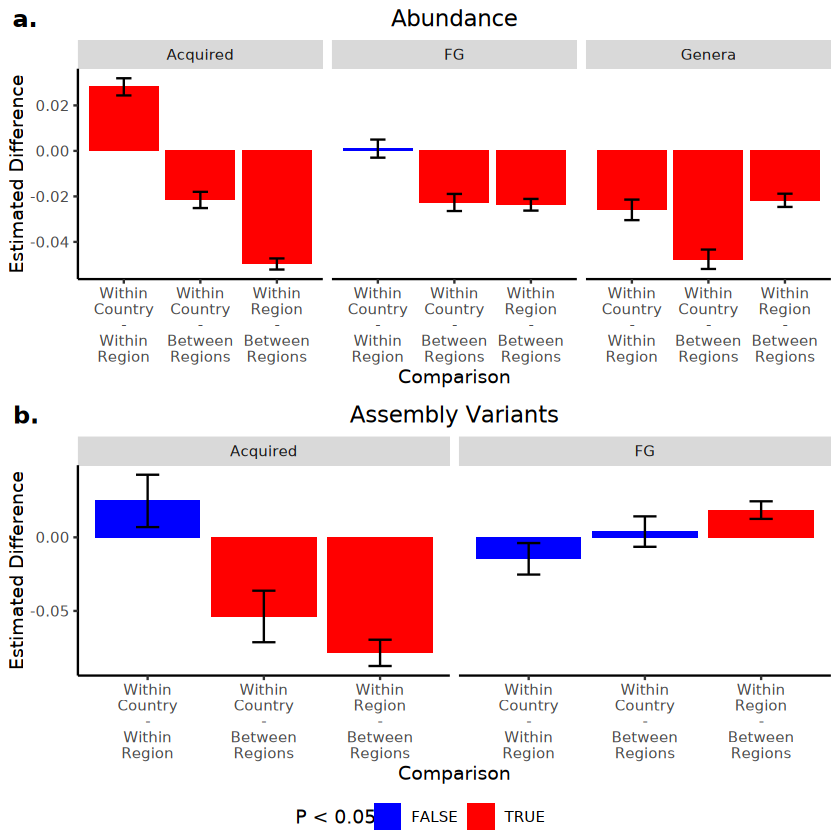

In [47]:
pairs.all <- rbind(
    abn.dists.rf.lms$pairs  %>% mutate(Collection = 'Acquired', data_type = 'Abundance'),
    abn.dists.fg.lms$pairs  %>% mutate(Collection = 'FG', data_type = 'Abundance'),
    abn.dists.bac.lms$pairs  %>% mutate(Collection = 'Genera', data_type = 'Abundance'),
    variants.dists.rf.lms$pairs %>% mutate(Collection = 'Acquired', data_type = 'Assembly variants'),
    variants.dists.fg.lms$pairs %>% mutate(Collection = 'FG', data_type = 'Assembly variants')

) %>% 
    #separate(contrast,into = c('s1', 's2'), sep = ' - ') %>%
    mutate(
        contrast = factor(
            str_replace_all(contrast, " ", "\n"),
            levels = c("Within\nCountry\n-\nWithin\nRegion", "Within\nCountry\n-\nBetween\nRegions", "Within\nRegion\n-\nBetween\nRegions")
        )
    )


p1 <- ggplot(pairs.all %>% filter(data_type == 'Abundance'), aes(x=contrast, y = estimate, fill=p.value < 0.05)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = estimate - SE, ymax = estimate + SE), width = 0.2) +
    facet_wrap(. ~ Collection) +
    scale_fill_manual(values = c("TRUE" = "red", "FALSE" = "blue"), name = paste("P", "<", 0.05)) +
    labs(x = 'Comparison', y = 'Estimated Difference', title = 'Abundance') +
    #theme_minimal() + 
    theme(
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.line = element_line(colour = "black"),
        plot.title = element_text(hjust = 0.5)
    )

p2 <- ggplot(pairs.all %>% filter(data_type != 'Abundance'), aes(x=contrast, y = estimate, fill=p.value < 0.05)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = estimate - SE, ymax = estimate + SE), width = 0.2) +
    facet_wrap(. ~ Collection) +
    scale_fill_manual(values = c("TRUE" = "red", "FALSE" = "blue"), name = paste("P", "<", 0.05)) +
    labs(x = 'Comparison', y = 'Estimated Difference', title = 'Assembly Variants') +
    #theme_minimal() + 
    theme(
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.line = element_line(colour = "black"),
        plot.title = element_text(hjust = 0.5)
    )

ggarrange(p1, p2, ncol=1, nrow=2, common.legend = T, legend = "bottom", labels = c("a.", "b."))
ggsave(file.path(fig.dir, 'dd_abundance_trend_comparisions.png'), width = 10, height = 7)